In [6]:
import os
import json
import pandas as pd
from collections import defaultdict
from collections import Counter

# Aggregations

In [9]:
def read(path,filename,metric):
    result=[]
    with open(path,'r') as f:
        dict_ = {}
        for line in f:
            token, score = line.split('\t')
            field = "_".join([filename,metric])
            dict_[token]=float(score[:-1])
        dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
        result = [{'task':filename, 'metric':metric, 'token':k, 'score':v, 'rank':i} for i, (k,v) in enumerate(dict_.items())]
        
    return result

def aggregate():
    results=[]
    metrics = ['cosine','distance','jsd']
    for metric in metrics:
        for filename in os.listdir(f"results/{metric}"):
            if filename!='discovery_noun' and filename!='discovery_verb': 
                print(filename)
                path = os.path.join(f"results/{metric}", filename)
                results += read(path, filename,metric)
    return results
        
all_results = aggregate()

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
nli
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
sst2
sst2_local_finetune
sst_hously
sst_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


In [10]:
# read in file
df = pd.DataFrame(all_results)
print(df)
df['score'] = df['score'].astype(float)
token_list = df['token'].values

             task  metric      token     score  rank
0       bert_base  cosine      plane  1.358319     0
1       bert_base  cosine     record  1.116720     1
2       bert_base  cosine     player  1.094999     2
3       bert_base  cosine     stroke  1.072125     3
4       bert_base  cosine   chairman  1.071409     4
...           ...     ...        ...       ...   ...
2104  textual_sim     jsd       head  0.162762    32
2105  textual_sim     jsd       face  0.152695    33
2106  textual_sim     jsd       word  0.128485    34
2107  textual_sim     jsd  multitude  0.111609    35
2108  textual_sim     jsd     donkey  0.075532    36

[2109 rows x 5 columns]


In [29]:
# majority ave/min/max files
def majority_vote(df, metric, method):
    df_metric = df[df['metric']==metric]
    token_list = set(df_metric['token'].tolist())
    print(len(token_list))
    token_rank = {token: Counter(df_metric[df_metric['token']==token]['rank'].tolist()).most_common()[0][0] for token in token_list}
    print(token_rank)
    
    with open(f"results/majority_vote_{metric}_{method}","w") as f:
        for token in token_list:
           
            target = df_metric[(df_metric['token']==token)&(df_metric['rank']==token_rank[token])]['score'].tolist()
          
            if method=='ave':
                score = sum(target)/len(target)
            elif method=='max':
                score = max(target)
            elif method=='min':
                score = min(target)
            f.write((token+'\t'+str(score)+'\n'))
        


In [38]:
majority_vote(df, 'jsd', 'ave')

37
{'twist': 28, 'head': 32, 'rag': 8, 'land': 17, 'multitude': 35, 'savage': 27, 'lass': 27, 'fiction': 11, 'record': 2, 'bit': 21, 'chairman': 1, 'relationship': 18, 'attack': 17, 'circle': 31, 'stroke': 15, 'plane': 0, 'graft': 5, 'edge': 26, 'tip': 8, 'ball': 14, 'gas': 18, 'bag': 19, 'player': 2, 'quilt': 7, 'tree': 25, 'prop': 22, 'word': 34, 'ounce': 6, 'thump': 30, 'face': 31, 'risk': 12, 'part': 26, 'pin': 4, 'contemplation': 36, 'donkey': 36, 'stab': 10, 'lane': 5}


In [12]:
# plain ave/min/max files
def no_vote(results,metric):
    df = pd.DataFrame(results)
    df['score'] = df['score'].astype(float)
    df_cosine = df[df['metric']==metric]

    res = pd.DataFrame(df_cosine.groupby(["token"]).min()).to_dict()
    with open(f"results/{metric}_min","w") as f:
        for k,v in res['score'].items():
            f.write(k+'\t'+str(v)+'\n')

In [13]:
for metric in ['cosine','distance','jsd']:
    no_vote(results,metric)

# decision tree

In [1]:
## feature a set of scores --- > change or not
## prepare feature
import csv
import sklearn
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
print(sklearn.__version__)

assert float(sklearn.__version__[2:]) >= 21, 'sklearn version insufficient.'

0.24.2


In [2]:
# load gold informaiton

path_1 = "../test_data_truth/task1/english.txt"
path_2 = "../test_data_truth/task2/english.txt"


with open(path_1,'r') as f:
    gold_info_dis = {}
    for line in f:
        token, score = line.split('\t')
        gold_info_dis[token]=float(score[:-1])

with open(path_2,'r') as f:
    gold_info_con = {}
    for line in f:
        token, score = line.split('\t')
        gold_info_con[token]=float(score[:-1])
        
token_list = list(gold_info_dis.keys())

print(gold_info_dis)
print(gold_info_con)

{'attack': 1.0, 'bag': 0.0, 'ball': 0.0, 'bit': 1.0, 'chairman': 0.0, 'circle': 1.0, 'contemplation': 0.0, 'donkey': 0.0, 'edge': 1.0, 'face': 0.0, 'fiction': 0.0, 'gas': 0.0, 'graft': 1.0, 'head': 1.0, 'land': 1.0, 'lane': 0.0, 'lass': 1.0, 'multitude': 0.0, 'ounce': 0.0, 'part': 0.0, 'pin': 0.0, 'plane': 1.0, 'player': 1.0, 'prop': 1.0, 'quilt': 0.0, 'rag': 1.0, 'record': 1.0, 'relationship': 0.0, 'risk': 0.0, 'savage': 0.0, 'stab': 1.0, 'stroke': 0.0, 'thump': 1.0, 'tip': 1.0, 'tree': 0.0, 'twist': 0.0, 'word': 0.0}
{'attack': 0.1439699927, 'bag': 0.1003636619, 'ball': 0.4093665525, 'bit': 0.3065766263, 'chairman': 0.0, 'circle': 0.1710871199, 'contemplation': 0.070838721, 'donkey': 0.1601038896, 'edge': 0.2609655868, 'face': 0.137791275, 'fiction': 0.0207232682, 'gas': 0.1595695865, 'graft': 0.5539755971, 'head': 0.2952561247, 'land': 0.2234476353, 'lane': 0.1037200629, 'lass': 0.2125896937, 'multitude': 0.1003636619, 'ounce': 0.2848990681, 'part': 0.161270809, 'pin': 0.2072118595,

In [3]:
def prepare_features(metric):
    new_dict = {item:defaultdict(dict) for item in token_list}
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb' and filename!='gold.txt': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            with open(path,'r') as f:
                for line in f:
                    token, score = line.split('\t')
                    field = "_".join([filename,metric])
                    new_dict[token][field]=float(score[:-1])
        
    return new_dict

def reformat_features(new_dict, gold_info_dis):
    for k,v in gold_info_dis.items():
        new_dict[k]['gold']=v
    reformat=[]
    for k,v in new_dict.items():
        tmp_dict={}
        tmp_dict['token']=k
        for k_,v_ in v.items():
            tmp_dict[k_]=v_
        reformat.append(tmp_dict)
    keys = reformat[0].keys()
    with open('dt_new.csv', 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(reformat)
        
def plot_tree(df):
    target = list(df.columns)
    target.remove("token")
    target.remove("gold")
    df1 = df[target]
    features = df1.to_numpy()
    gold = df['gold'].values
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(features, gold)
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, 
                  feature_names=target,
                  class_names=['unchanged','changed'],
                  filled=True, 
                  rounded=True, 
                  fontsize=14)
    plt.show()
        
        



bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


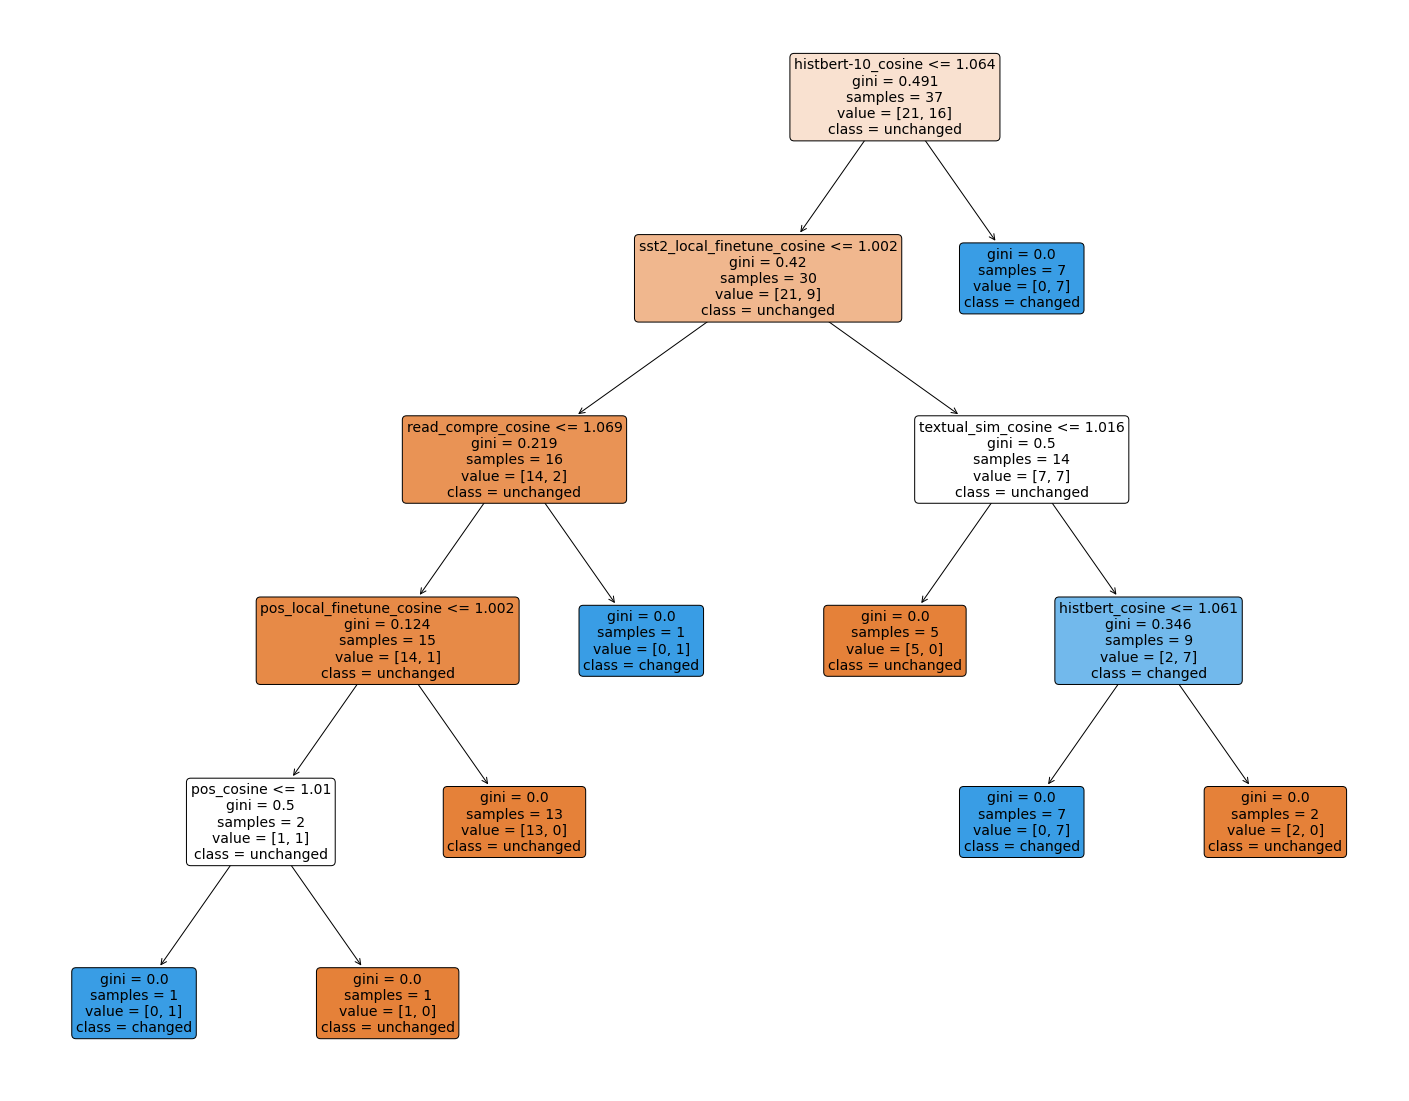

In [7]:
# cosine: PRT
new_dict = prepare_features('cosine')  
reformat_features(new_dict, gold_info_dis)
df = pd.read_csv('dt_new.csv')
plot_tree(df)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


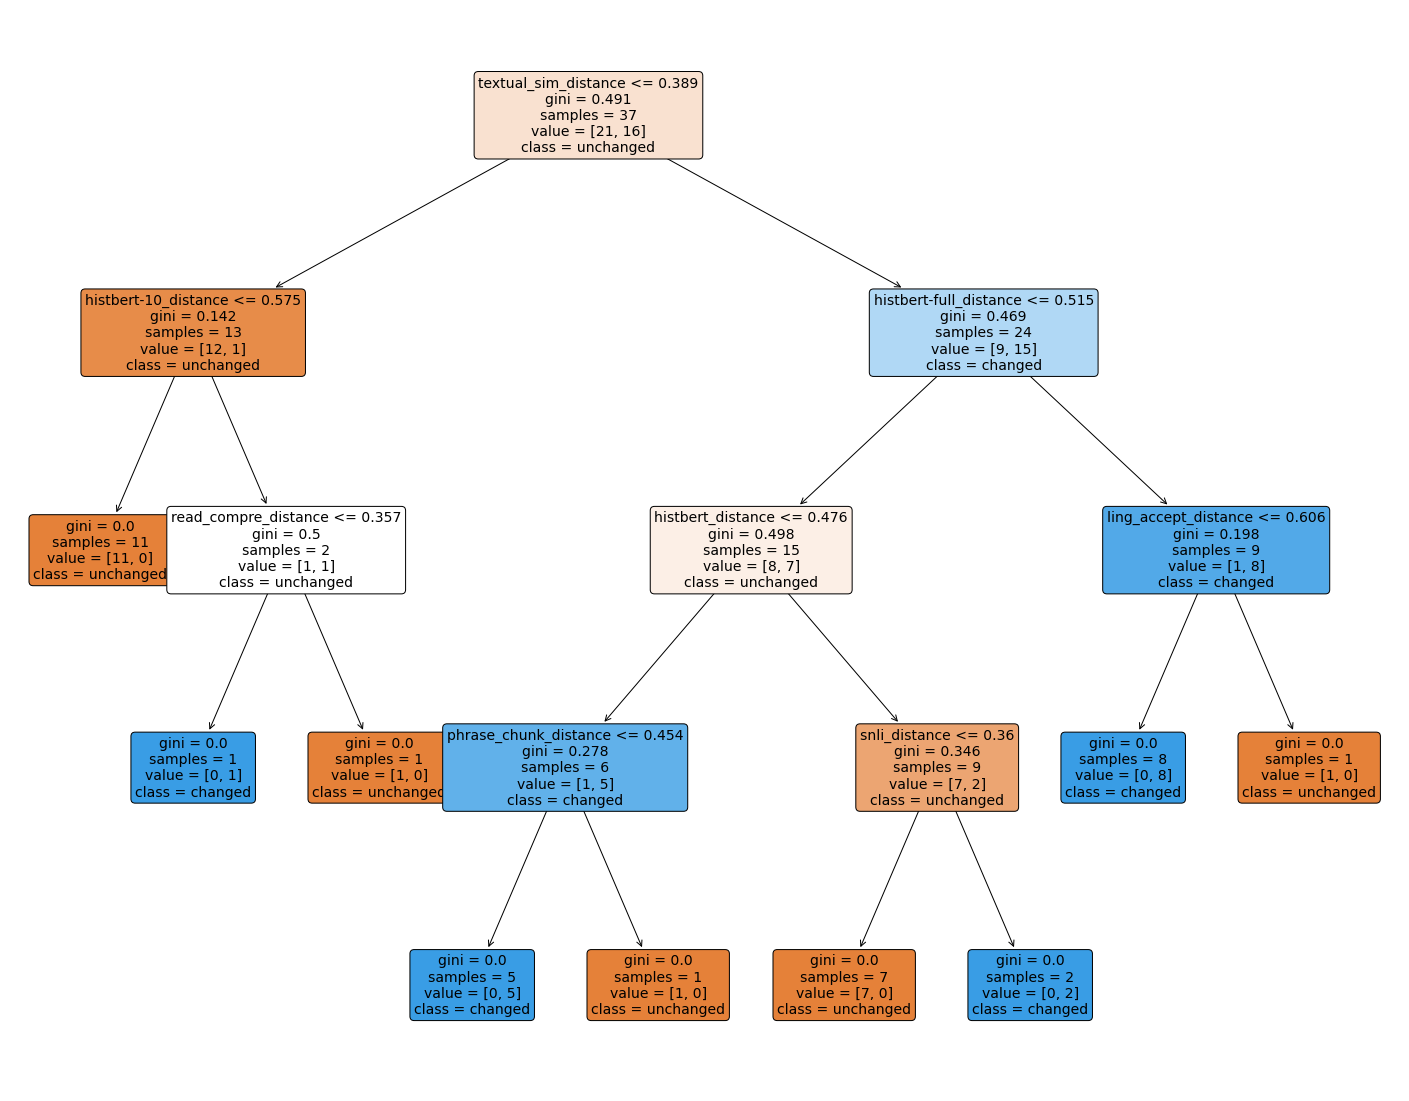

In [8]:
# distance: APD
new_dict = prepare_features('distance')  
reformat_features(new_dict, gold_info_dis)
df = pd.read_csv('dt_new.csv')
plot_tree(df)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


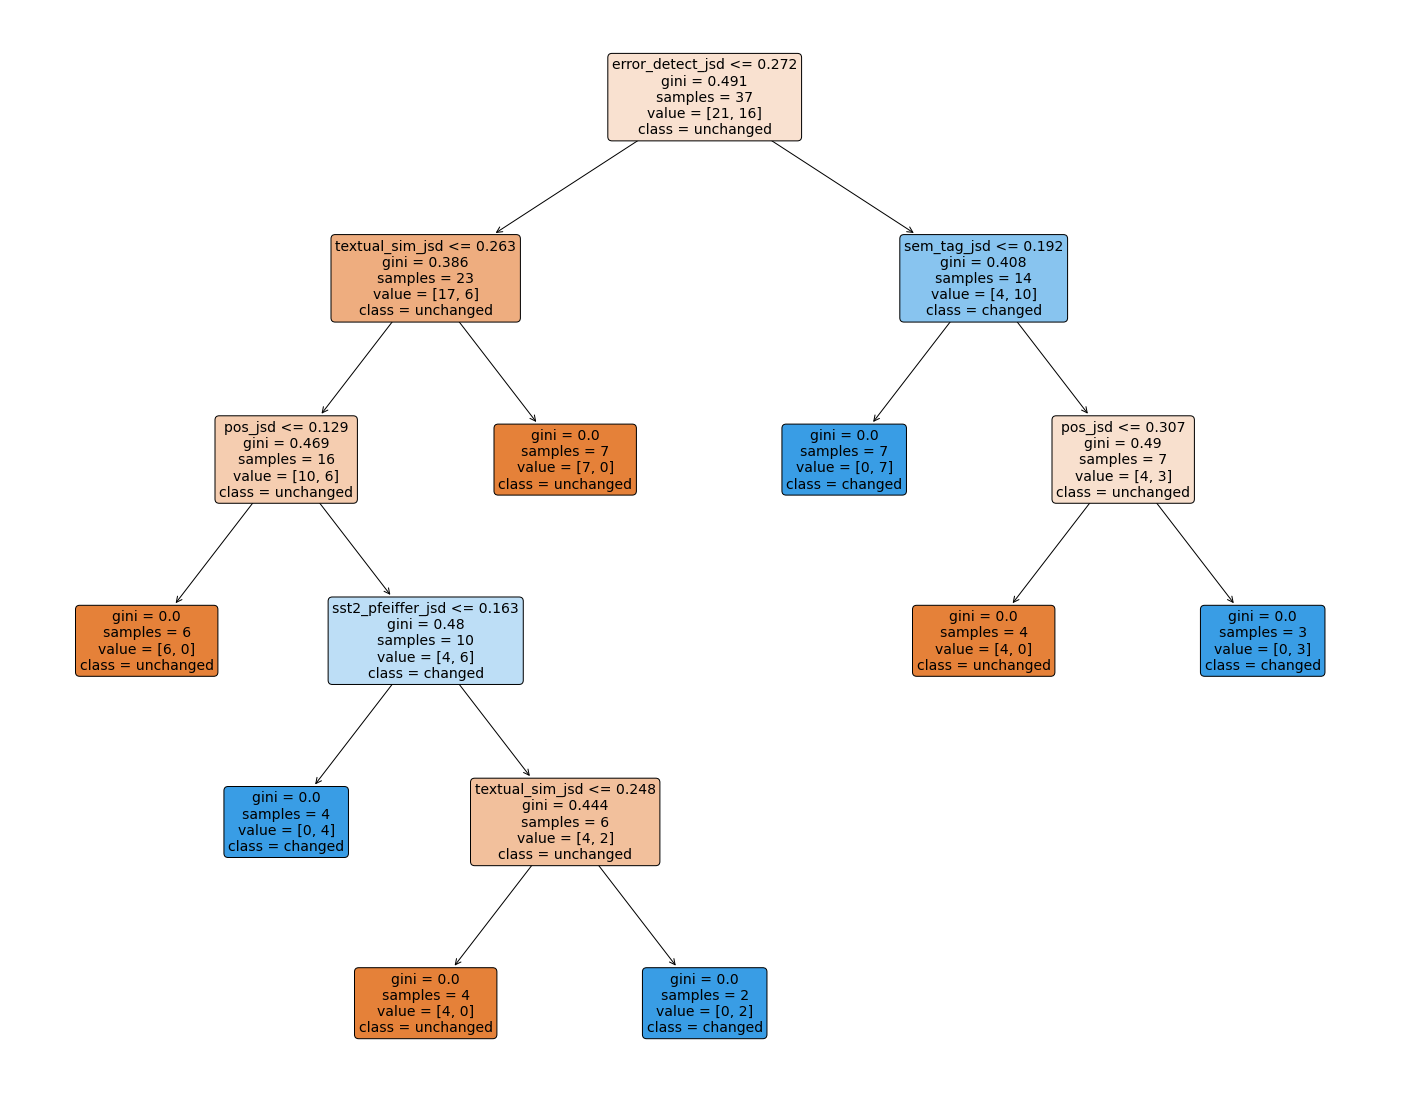

In [9]:
new_dict = prepare_features('jsd')  
reformat_features(new_dict, gold_info_dis)
df = pd.read_csv('dt_new.csv')
plot_tree(df)

# decision tree individual scores

In [10]:
import os
import csv
import sklearn
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [11]:
def prepare_features(metric):
    new_dict = {item:defaultdict(dict) for item in token_list}
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb' and filename!='gold.txt': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            with open(path,'r') as f:
                for line in f:
                    token, score = line.split('\t')
                    field = "_".join([filename,metric])
                    new_dict[token][field]=float(score[:-1])
        
    return new_dict

def reformat_features(new_dict, gold_info_dis):
    for k,v in gold_info_dis.items():
        new_dict[k]['gold']=v
    reformat=[]
    for k,v in new_dict.items():
        tmp_dict={}
        tmp_dict['token']=k
        for k_,v_ in v.items():
            tmp_dict[k_]=v_
        reformat.append(tmp_dict)
    return pd.DataFrame(reformat)
        
def plot_tree(df):
    tokens = df['token']
    gold = df['gold'].values
    target = list(df.columns)
    target.remove("token")
    target.remove("gold")
    df1 = df[target]
    features = df1.to_numpy()
    X_train, X_test = features[:26], features[26:]
    y_train, y_test = gold[:26], gold[26:]
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy', sum(y_pred==y_test)/len(y_pred))
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, 
                  feature_names=target,
                  class_names=['0','1'],
                  filled=True, 
                  rounded=True, 
                  fontsize=14)
    plt.show()
        

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy 0.6363636363636364


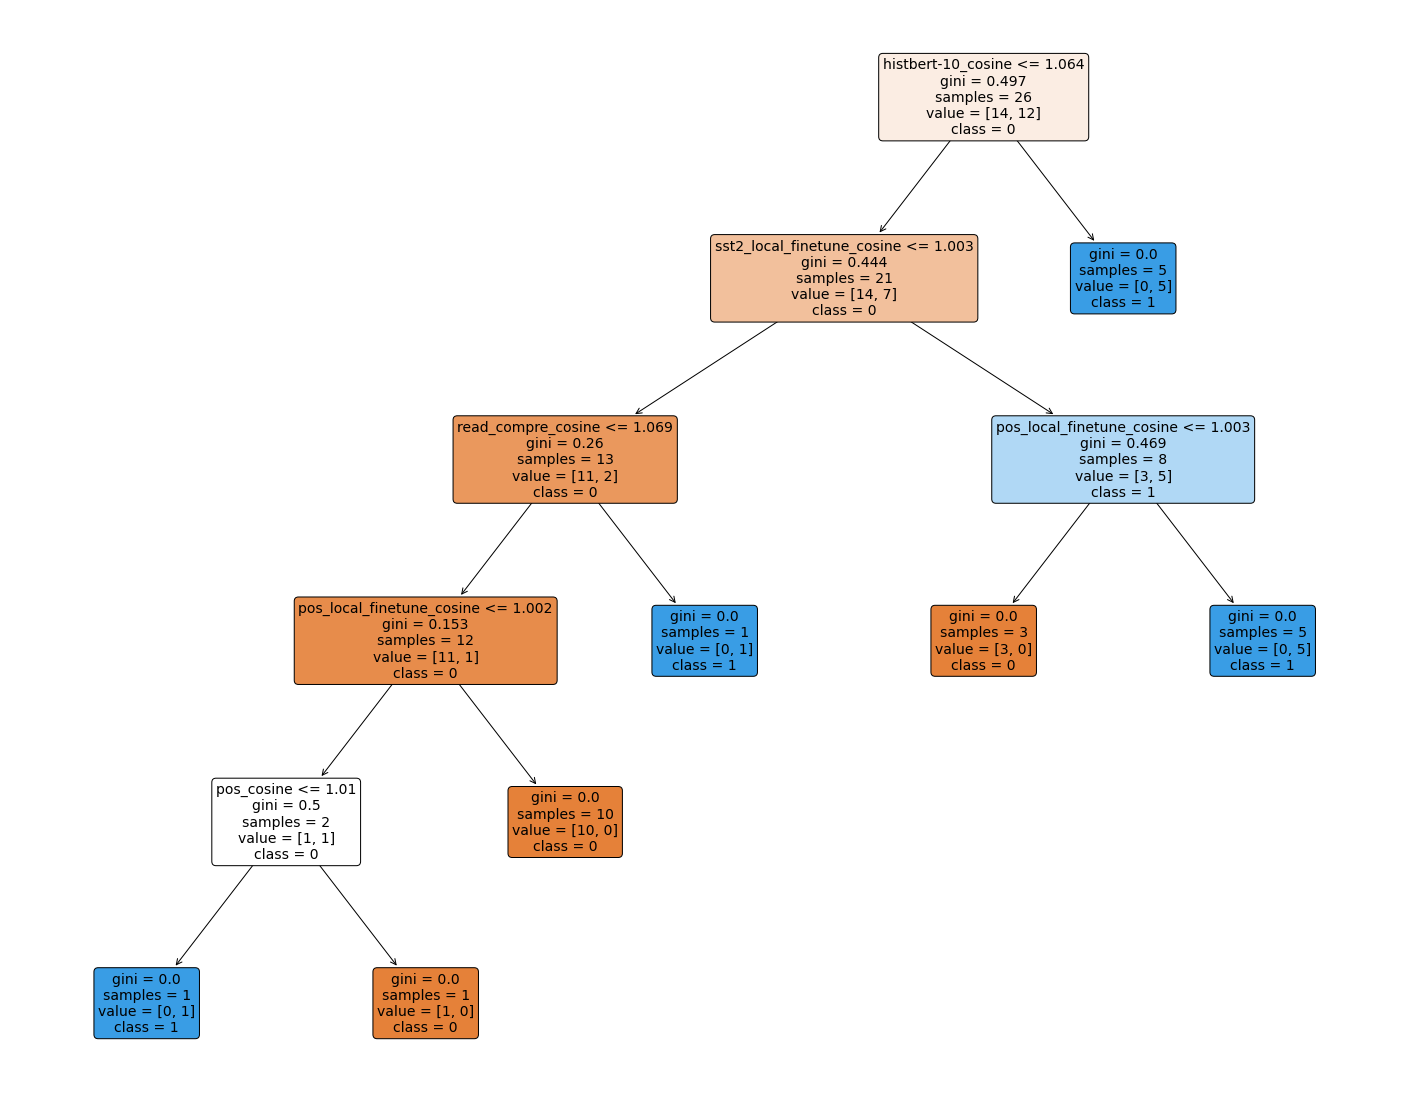

In [12]:
# cosine: PRT
new_dict = prepare_features('cosine')
df = reformat_features(new_dict, gold_info_dis)
plot_tree(df)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy 0.5454545454545454


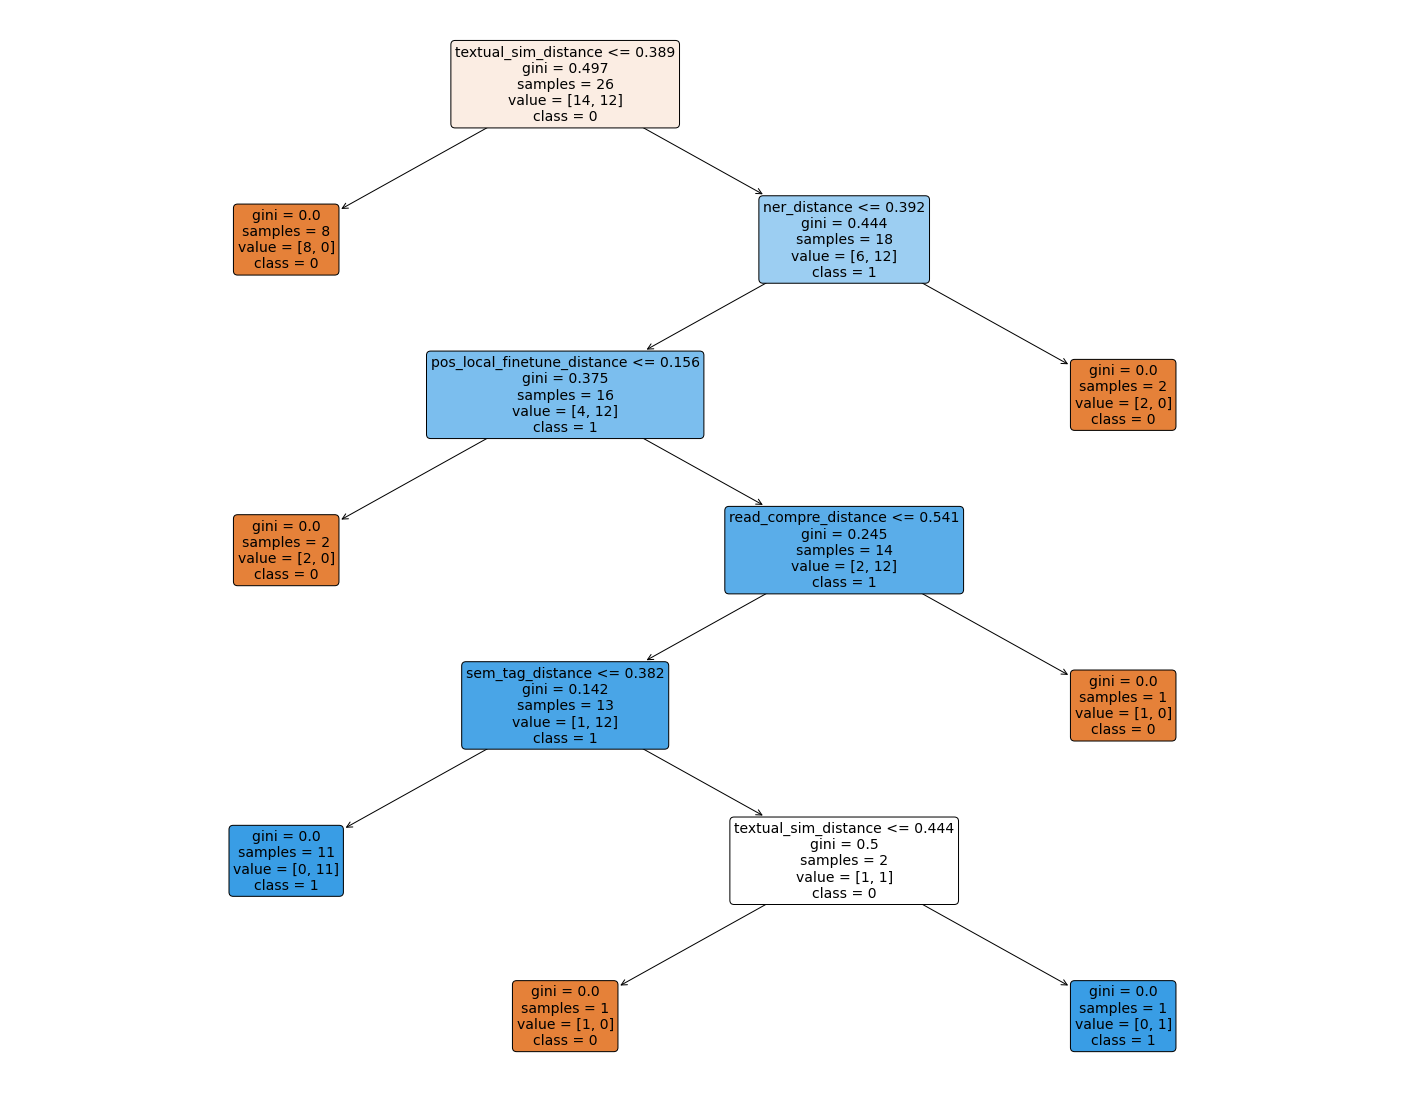

In [13]:
# cosine: APD
new_dict = prepare_features('distance')
df = reformat_features(new_dict, gold_info_dis)
plot_tree(df)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy 0.36363636363636365


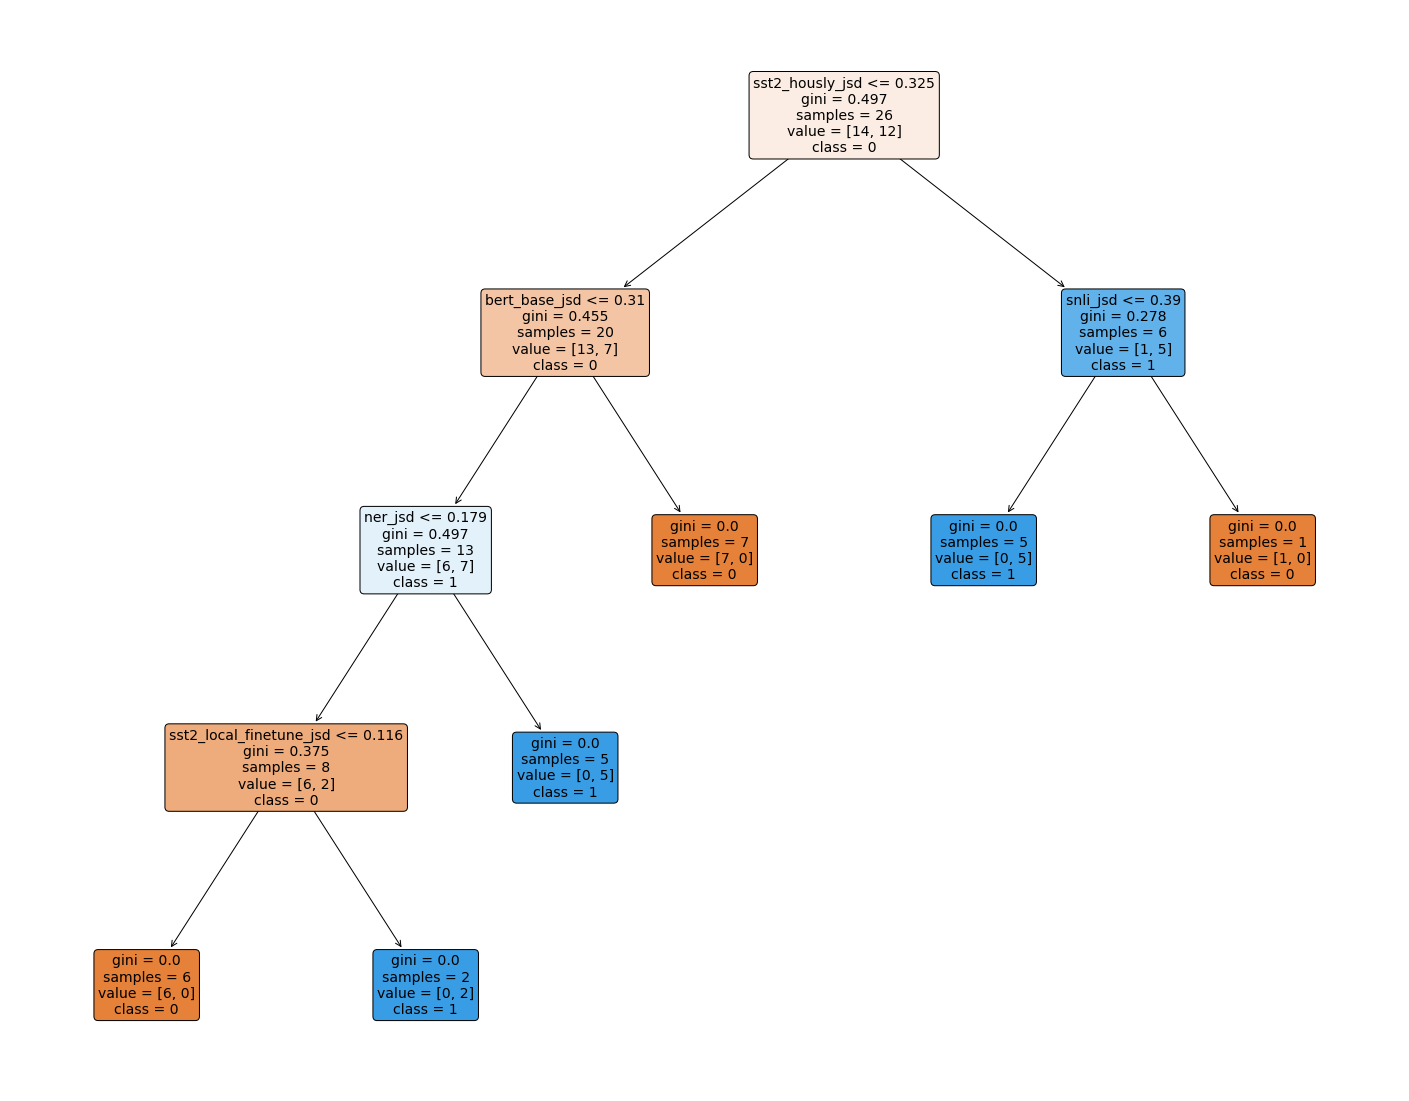

In [14]:
# cosine: JSD
new_dict = prepare_features('jsd')
df = reformat_features(new_dict, gold_info_dis)
plot_tree(df)

# using APD for train and test on PRT

In [15]:
def plot_tree_all(df1,df2):
    tokens = df1['token']
    target = list(df1.columns)
    target.remove("token")
    target.remove("gold")
    new_target = ['_'.join(item.split('_')[:-1]) for item in target]
    df1_ = df1[target]
    features1 = df1_.to_numpy()
    gold1 = df1['gold'].values

    target2 = list(df2.columns)
    target2.remove("token")
    target2.remove("gold")
    new_target2 = ['_'.join(item.split('_')[:-1]) for item in target2]
    df2_ = df2[target2]
    features2 = df2_.to_numpy()
    gold2 = df2['gold'].values

    assert new_target==new_target2
    #assert gold1==gold2
 
    X_train, X_test = features1, features2
    y_train, y_test = gold1, gold2
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
       
    for i, item in enumerate(gold1):
        print(tokens[i],item,y_pred[i])
    
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, 
                  feature_names=target,
                  class_names=['0','1'],
                  filled=True, 
                  rounded=True, 
                  fontsize=14)
    plt.show()


bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.5675675675675675
attack 1.0 0.0
bag 0.0 0.0
ball 0.0 0.0
bit 1.0 0.0
chairman 0.0 0.0
circle 1.0 0.0
contemplation 0.0 0.0
donkey 0.0 0.0
edge 1.0 0.0
face 0.0 0.0
fiction 0.0 0.0
gas 0.0 0.0
graft 1.0 0.0
head 1.0 0.0
land 1.0 0.0
lane 0.0 0.0
lass 1.0 0.0
multitude 0.0 0.0
ounce 0.0 0.0
part 0.0 0.0
pin 0.0 0.0
plane 1.0 0.0
player 1.0 0.0
prop 1.0 0.0
quilt 0.0 0.0
rag 1.0 0.0
record 1.0 0.0
relationship 0.0 0.0
risk 0.0 0.0
savage 0.0 0.0
stab 1.0 0.0
stroke 0.0 0.0
thump 1.0 0.0
tip 1.0 0.0
tree 0.0 0.0
twist 0.0 0.0
word 0.0 0.0


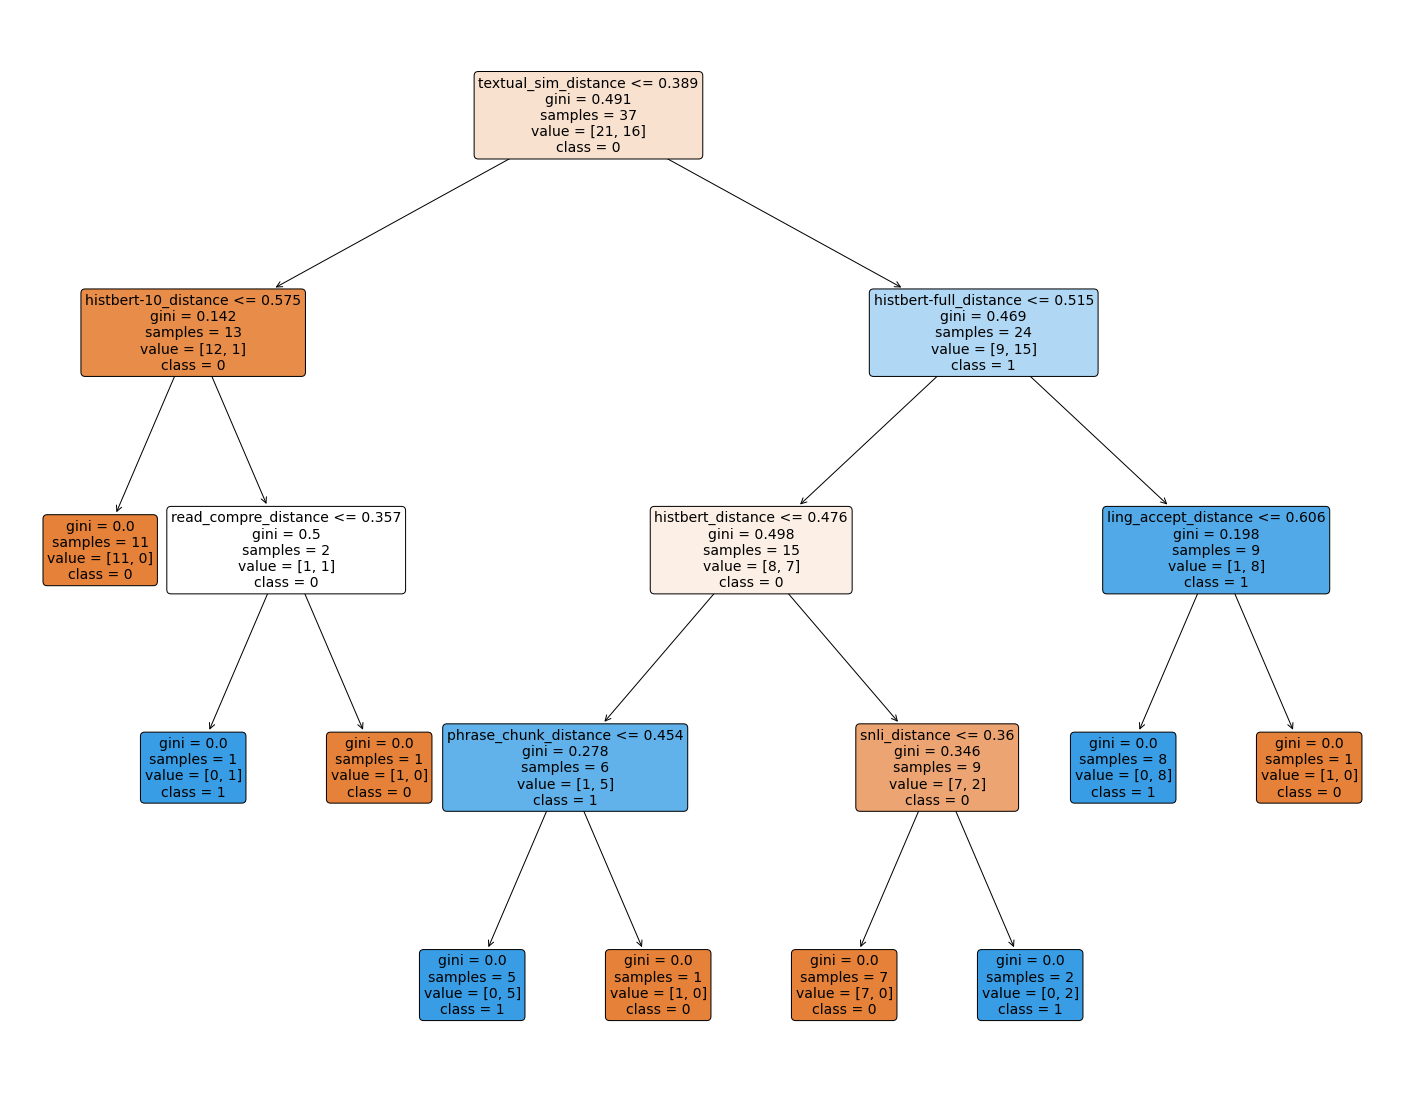

In [16]:
new_dict = prepare_features('distance')
df1 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df2 = reformat_features(new_dict, gold_info_dis)
plot_tree_all(df1,df2)

# use PRT for training and test on APD

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.43243243243243246
attack 1.0 1.0
bag 0.0 1.0
ball 0.0 1.0
bit 1.0 1.0
chairman 0.0 1.0
circle 1.0 1.0
contemplation 0.0 1.0
donkey 0.0 1.0
edge 1.0 1.0
face 0.0 1.0
fiction 0.0 1.0
gas 0.0 1.0
graft 1.0 1.0
head 1.0 1.0
land 1.0 1.0
lane 0.0 1.0
lass 1.0 1.0
multitude 0.0 1.0
ounce 0.0 1.0
part 0.0 1.0
pin 0.0 1.0
plane 1.0 1.0
player 1.0 1.0
prop 1.0 1.0
quilt 0.0 1.0
rag 1.0 1.0
record 1.0 1.0
relationship 0.0 1.0
risk 0.0 1.0
savage 0.0 1.0
stab 1.0 1.0
stroke 0.0 1.0
thump 1.0 1.0
tip 1.0 1.0
tree 0.0 1.0
twist 0.0 1.0
word 0.0 1.0


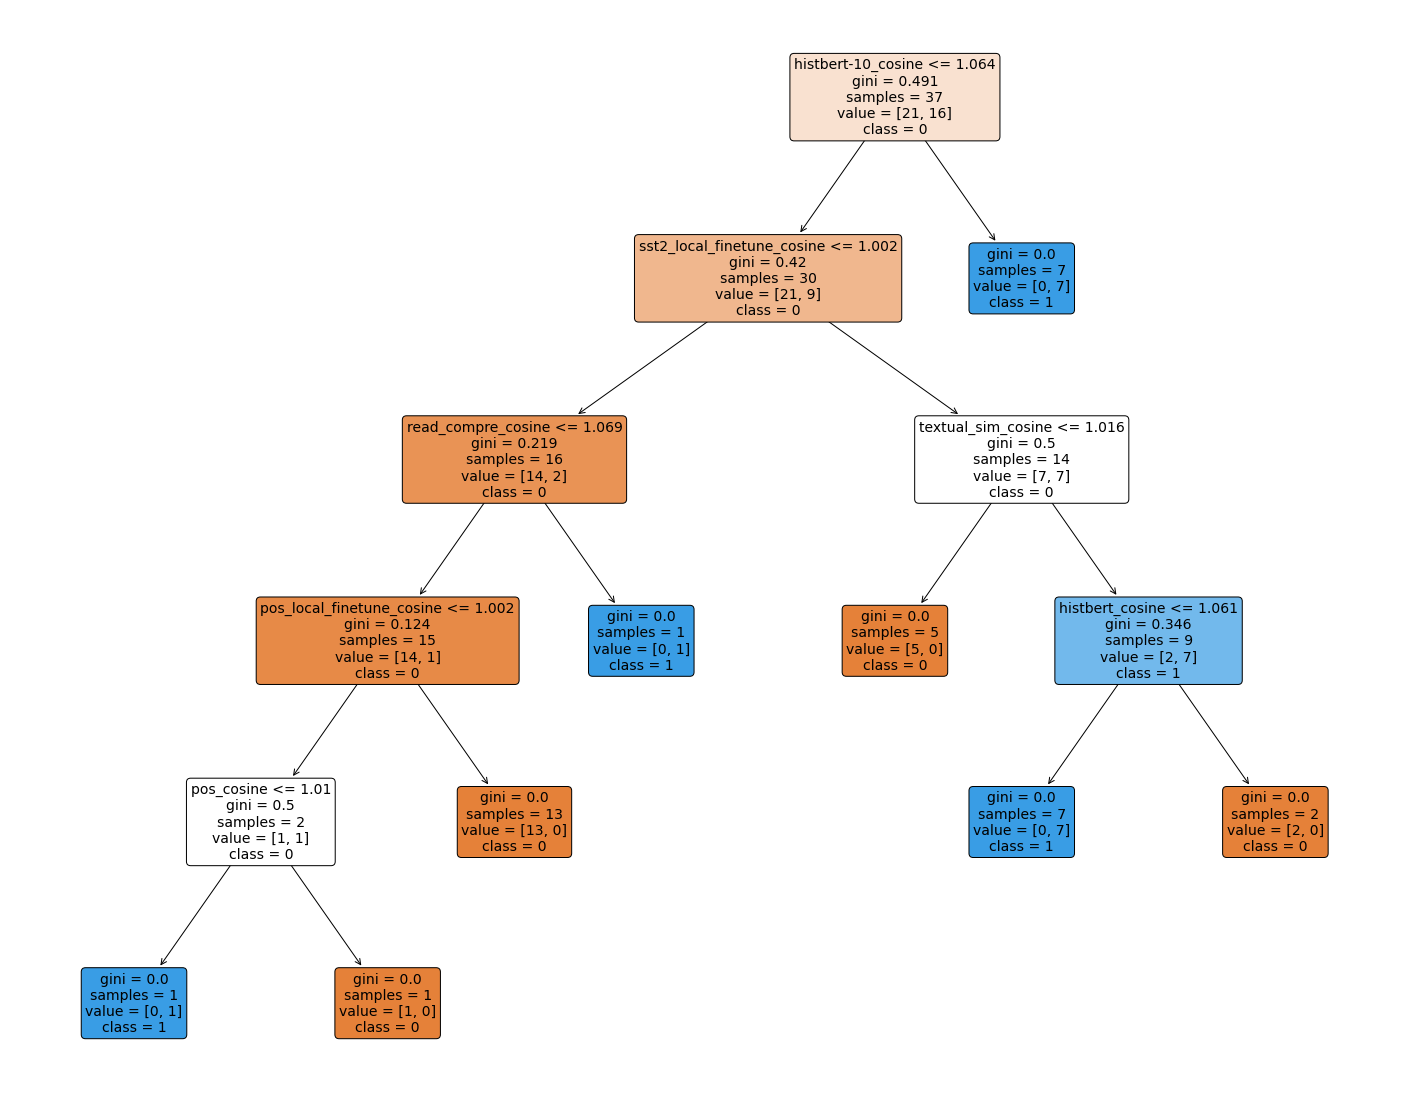

In [17]:
new_dict = prepare_features('distance')
df2 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df1 = reformat_features(new_dict, gold_info_dis)
plot_tree_all(df1,df2)

# convert to z score

In [18]:
from scipy.stats import zscore
def plot_tree_all_z(df1,df2):
    tokens = df1['token']
    target = list(df1.columns)
    target.remove("token")
    target.remove("gold")
    new_target = ['_'.join(item.split('_')[:-1]) for item in target]
    df1_ = df1[target]
    df1_ = df1_.apply(zscore)
    features1 = df1_.to_numpy()
    gold1 = df1['gold'].values

    target2 = list(df2.columns)
    target2.remove("token")
    target2.remove("gold")
    new_target2 = ['_'.join(item.split('_')[:-1]) for item in target2]
    df2_ = df2[target2]
    df2_ = df2_.apply(zscore)
    features2 = df2_.to_numpy()
    gold2 = df2['gold'].values

    assert new_target==new_target2
    #assert gold1==gold2
 
    X_train, X_test = features1, features2
    y_train, y_test = gold1, gold2
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:",sum(y_pred==y_test)/len(y_pred))
       
    for i, item in enumerate(gold1):
        print(tokens[i],item,y_pred[i])
    
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, 
                  feature_names=target,
                  class_names=['0','1'],
                  filled=True, 
                  rounded=True, 
                  fontsize=14)
    plt.show()
    
    

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.5675675675675675
attack 1.0 1.0
bag 0.0 0.0
ball 0.0 0.0
bit 1.0 0.0
chairman 0.0 1.0
circle 1.0 0.0
contemplation 0.0 0.0
donkey 0.0 0.0
edge 1.0 0.0
face 0.0 0.0
fiction 0.0 0.0
gas 0.0 1.0
graft 1.0 1.0
head 1.0 0.0
land 1.0 0.0
lane 0.0 0.0
lass 1.0 1.0
multitude 0.0 1.0
ounce 0.0 1.0
part 0.0 0.0
pin 0.0 0.0
plane 1.0 0.0
player 1.0 1.0
prop 1.0 1.0
quilt 0.0 1.0
rag 1.0 0.0
record 1.0 1.0
relationship 0.0 0.0
risk 0.0 1.0
savage 0.0 0.0
stab 1.0 1.0
stroke 0.0 1.0
thump 1.0 0.0
tip 1.0 0.0
tree 0.0 0.0
twist 0.0 0.0
word 0.0 0.0


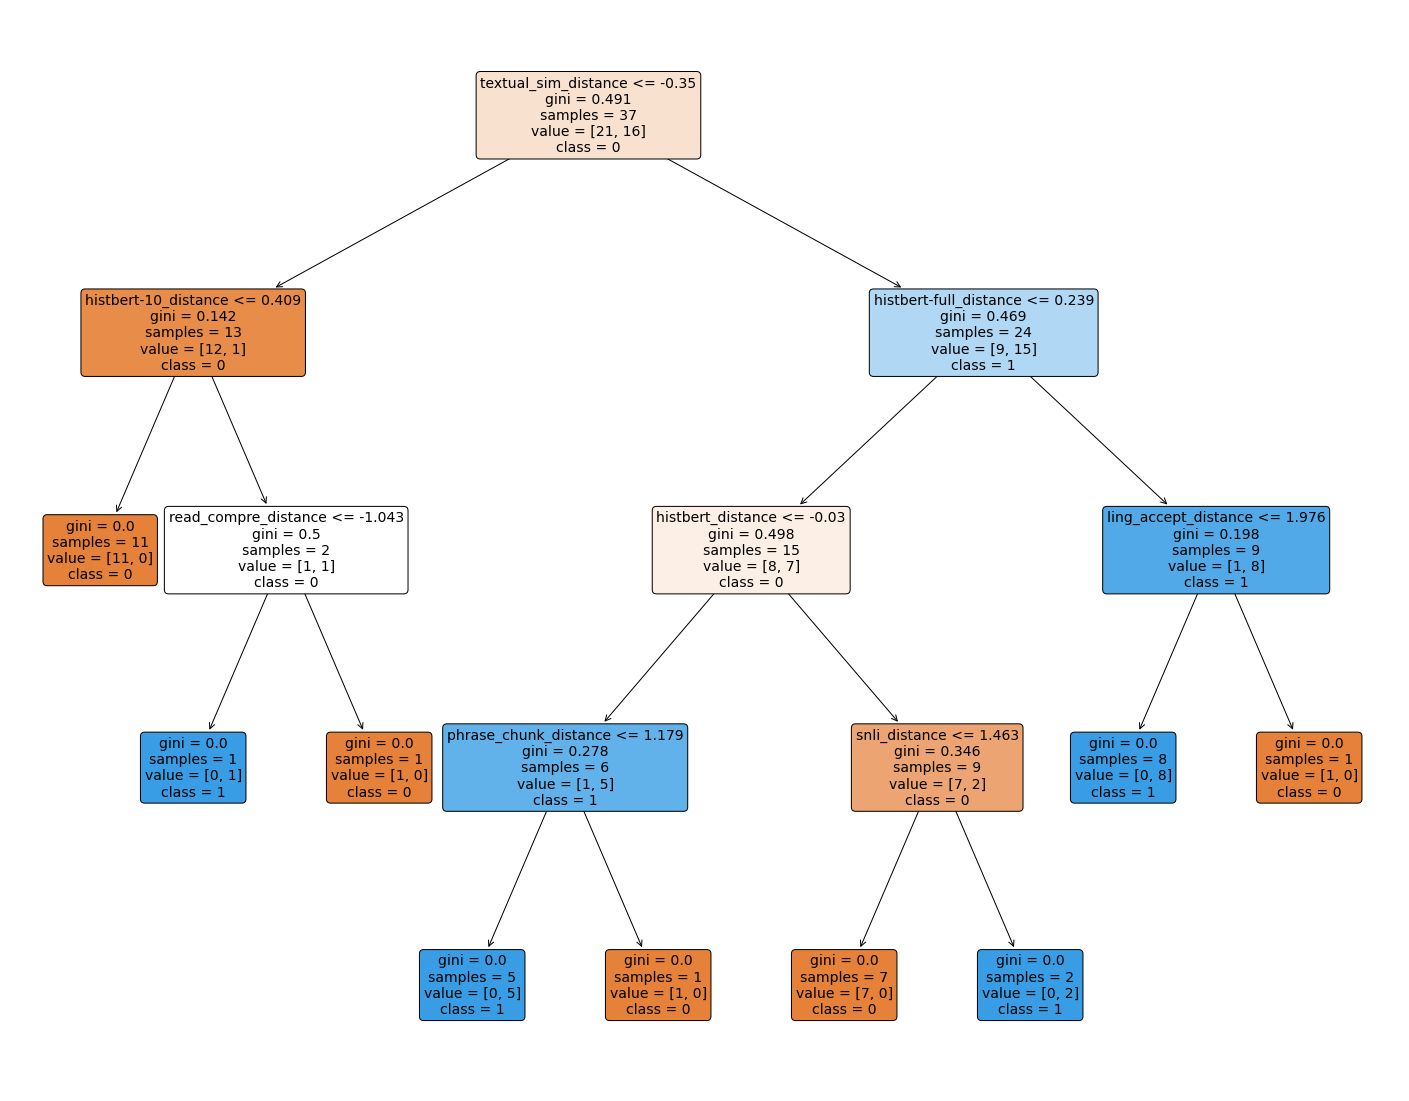

In [19]:
new_dict = prepare_features('distance')
df1 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df2 = reformat_features(new_dict, gold_info_dis)
plot_tree_all_z(df1,df2)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.7297297297297297
attack 1.0 0.0
bag 0.0 0.0
ball 0.0 1.0
bit 1.0 0.0
chairman 0.0 0.0
circle 1.0 1.0
contemplation 0.0 1.0
donkey 0.0 0.0
edge 1.0 1.0
face 0.0 0.0
fiction 0.0 0.0
gas 0.0 1.0
graft 1.0 1.0
head 1.0 0.0
land 1.0 1.0
lane 0.0 1.0
lass 1.0 1.0
multitude 0.0 0.0
ounce 0.0 0.0
part 0.0 0.0
pin 0.0 1.0
plane 1.0 1.0
player 1.0 1.0
prop 1.0 1.0
quilt 0.0 0.0
rag 1.0 1.0
record 1.0 0.0
relationship 0.0 0.0
risk 0.0 1.0
savage 0.0 0.0
stab 1.0 1.0
stroke 0.0 0.0
thump 1.0 1.0
tip 1.0 1.0
tree 0.0 0.0
twist 0.0 0.0
word 0.0 0.0


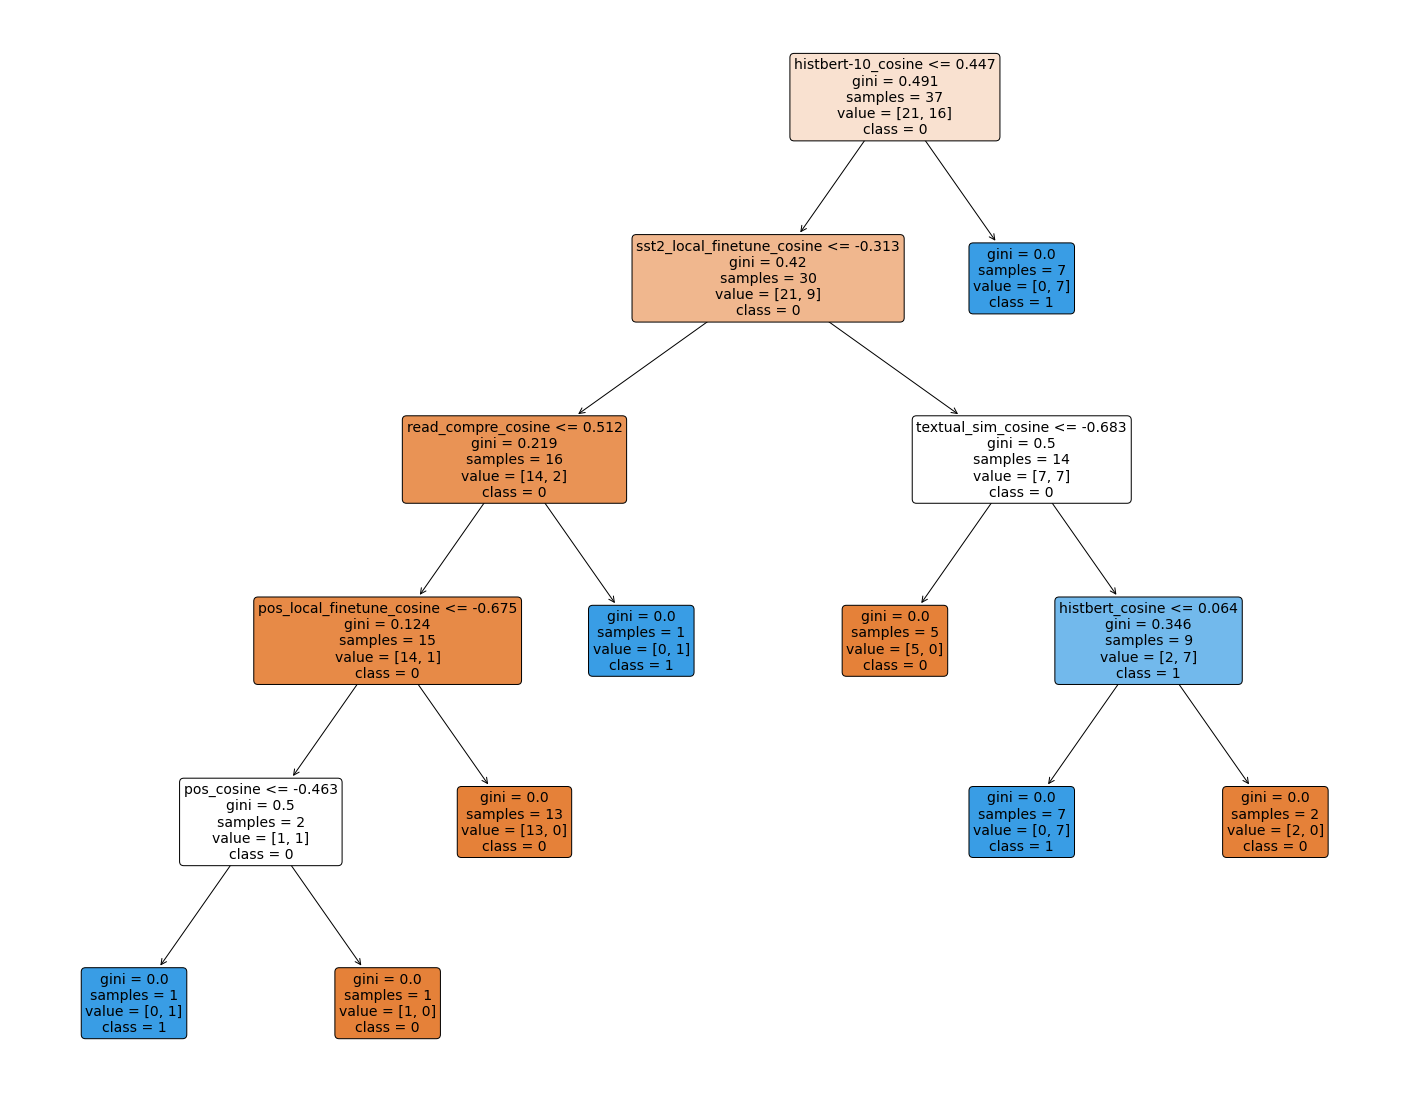

In [20]:
new_dict = prepare_features('distance')
df2 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df1 = reformat_features(new_dict, gold_info_dis)
plot_tree_all_z(df1,df2)

# prune

In [27]:
# APD TRAIN
# PRT TEST

consider_features=['textual_sim_distance','histbert-10_distance','histbert-full_distance','snli_distance','histbert_distance','ling_accept_distance']
consider_features2=['textual_sim_cosine','histbert-10_cosine','histbert-full_cosine','snli_cosine','histbert_cosine','ling_accept_cosine']


def plot_tree_all_prune(df1,df2,consider_features, consider_features2):
    tokens = df1['token']
    target = list(df1.columns)
    target.remove("token")
    target.remove("gold")
    new_target = ['_'.join(item.split('_')[:-1]) for item in target]
    df1_ = df1[consider_features]
    df1_ = df1_.apply(zscore)
    features1 = df1_.to_numpy()
    gold1 = df1['gold'].values

    target2 = list(df2.columns)
    target2.remove("token")
    target2.remove("gold")
    new_target2 = ['_'.join(item.split('_')[:-1]) for item in target2]
    df2_ = df2[consider_features2]
    df2_ = df2_.apply(zscore)
    features2 = df2_.to_numpy()
    gold2 = df2['gold'].values

    assert new_target==new_target2
    #assert gold1==gold2
 
    X_train, X_test = features1, features2
    y_train, y_test = gold1, gold2
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
       
    for i, item in enumerate(gold1):
        print(tokens[i],item,y_pred[i])
    
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, 
                  feature_names=consider_features,
                  class_names=['0','1'],
                  filled=True, 
                  rounded=True, 
                  fontsize=14)
    plt.show()
    return 



bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.5405405405405406
attack 1.0 1.0
bag 0.0 0.0
ball 0.0 0.0
bit 1.0 0.0
chairman 0.0 1.0
circle 1.0 0.0
contemplation 0.0 0.0
donkey 0.0 0.0
edge 1.0 0.0
face 0.0 0.0
fiction 0.0 0.0
gas 0.0 1.0
graft 1.0 1.0
head 1.0 0.0
land 1.0 0.0
lane 0.0 0.0
lass 1.0 1.0
multitude 0.0 1.0
ounce 0.0 1.0
part 0.0 1.0
pin 0.0 0.0
plane 1.0 0.0
player 1.0 1.0
prop 1.0 1.0
quilt 0.0 1.0
rag 1.0 0.0
record 1.0 1.0
relationship 0.0 0.0
risk 0.0 1.0
savage 0.0 0.0
stab 1.0 1.0
stroke 0.0 1.0
thump 1.0 0.0
tip 1.0 0.0
tree 0.0 0.0
twist 0.0 0.0
word 0.0 0.0


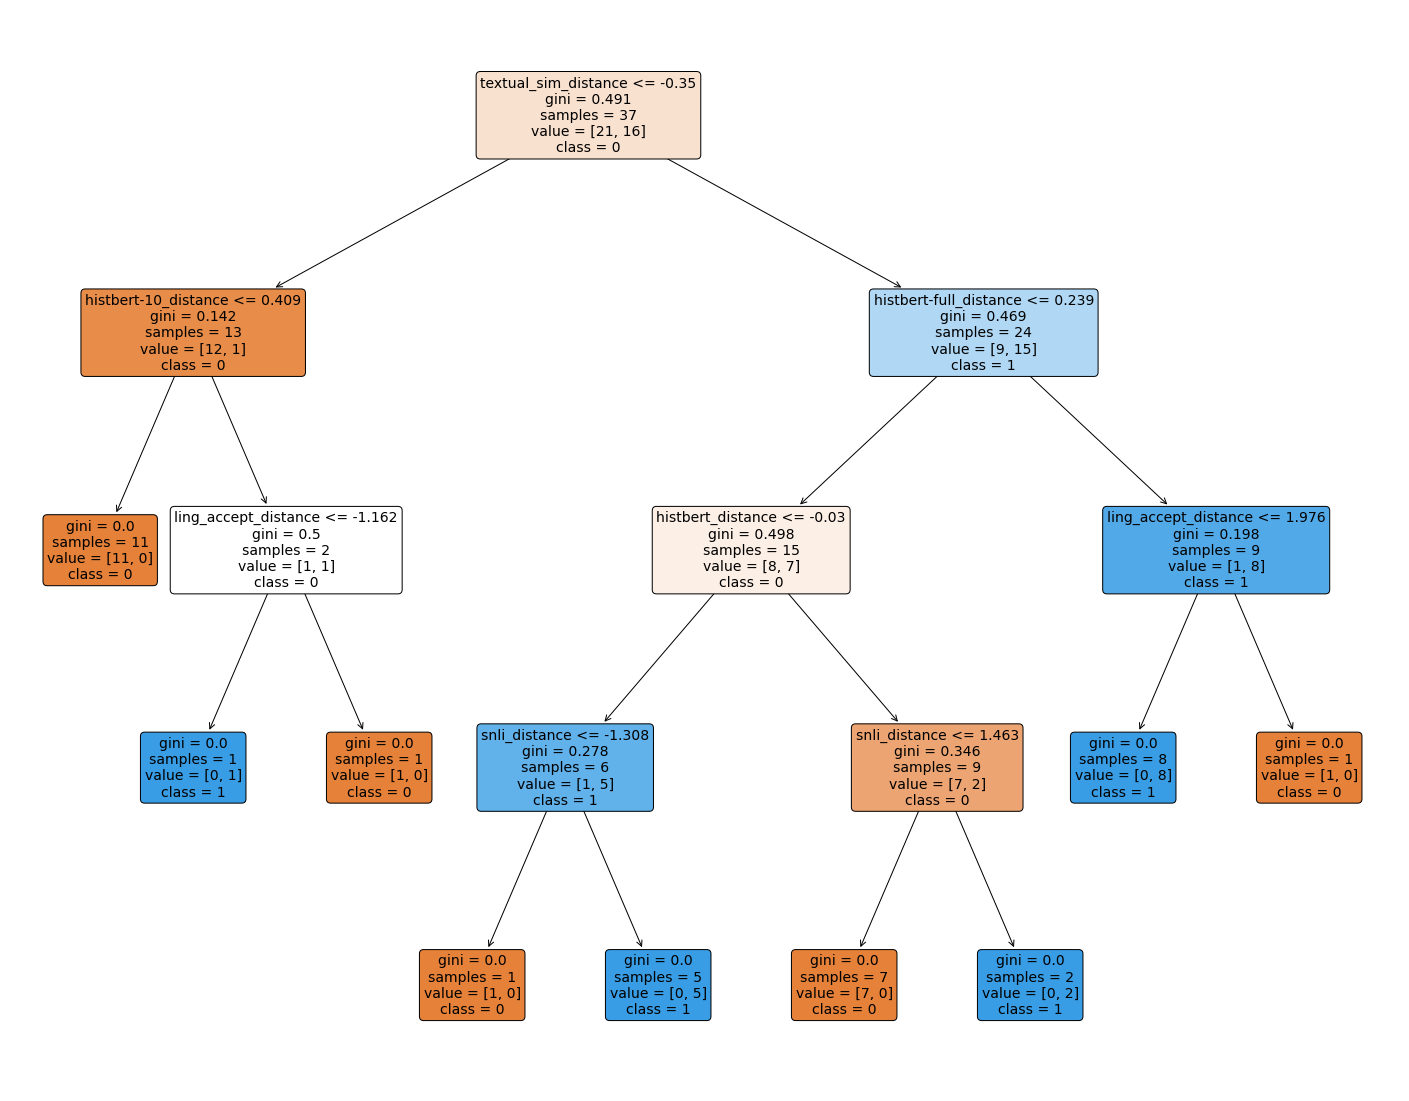

In [28]:
new_dict = prepare_features('distance')
df1 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df2 = reformat_features(new_dict, gold_info_dis)
plot_tree_all_prune(df1,df2,consider_features, consider_features2)

bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
Accuracy: 0.6216216216216216
attack 1.0 0.0
bag 0.0 0.0
ball 0.0 1.0
bit 1.0 0.0
chairman 0.0 0.0
circle 1.0 1.0
contemplation 0.0 1.0
donkey 0.0 0.0
edge 1.0 0.0
face 0.0 0.0
fiction 0.0 0.0
gas 0.0 1.0
graft 1.0 1.0
head 1.0 0.0
land 1.0 0.0
lane 0.0 1.0
lass 1.0 1.0
multitude 0.0 0.0
ounce 0.0 0.0
part 0.0 0.0
pin 0.0 1.0
plane 1.0 1.0
player 1.0 0.0
prop 1.0 1.0
quilt 0.0 0.0
rag 1.0 1.0
record 1.0 0.0
relationship 0.0 0.0
risk 0.0 1.0
savage 0.0 0.0
stab 1.0 1.0
stroke 0.0 0.0
thump 1.0 1.0
tip 1.0 1.0
tree 0.0 0.0
twist 0.0 1.0
word 0.0 0.0


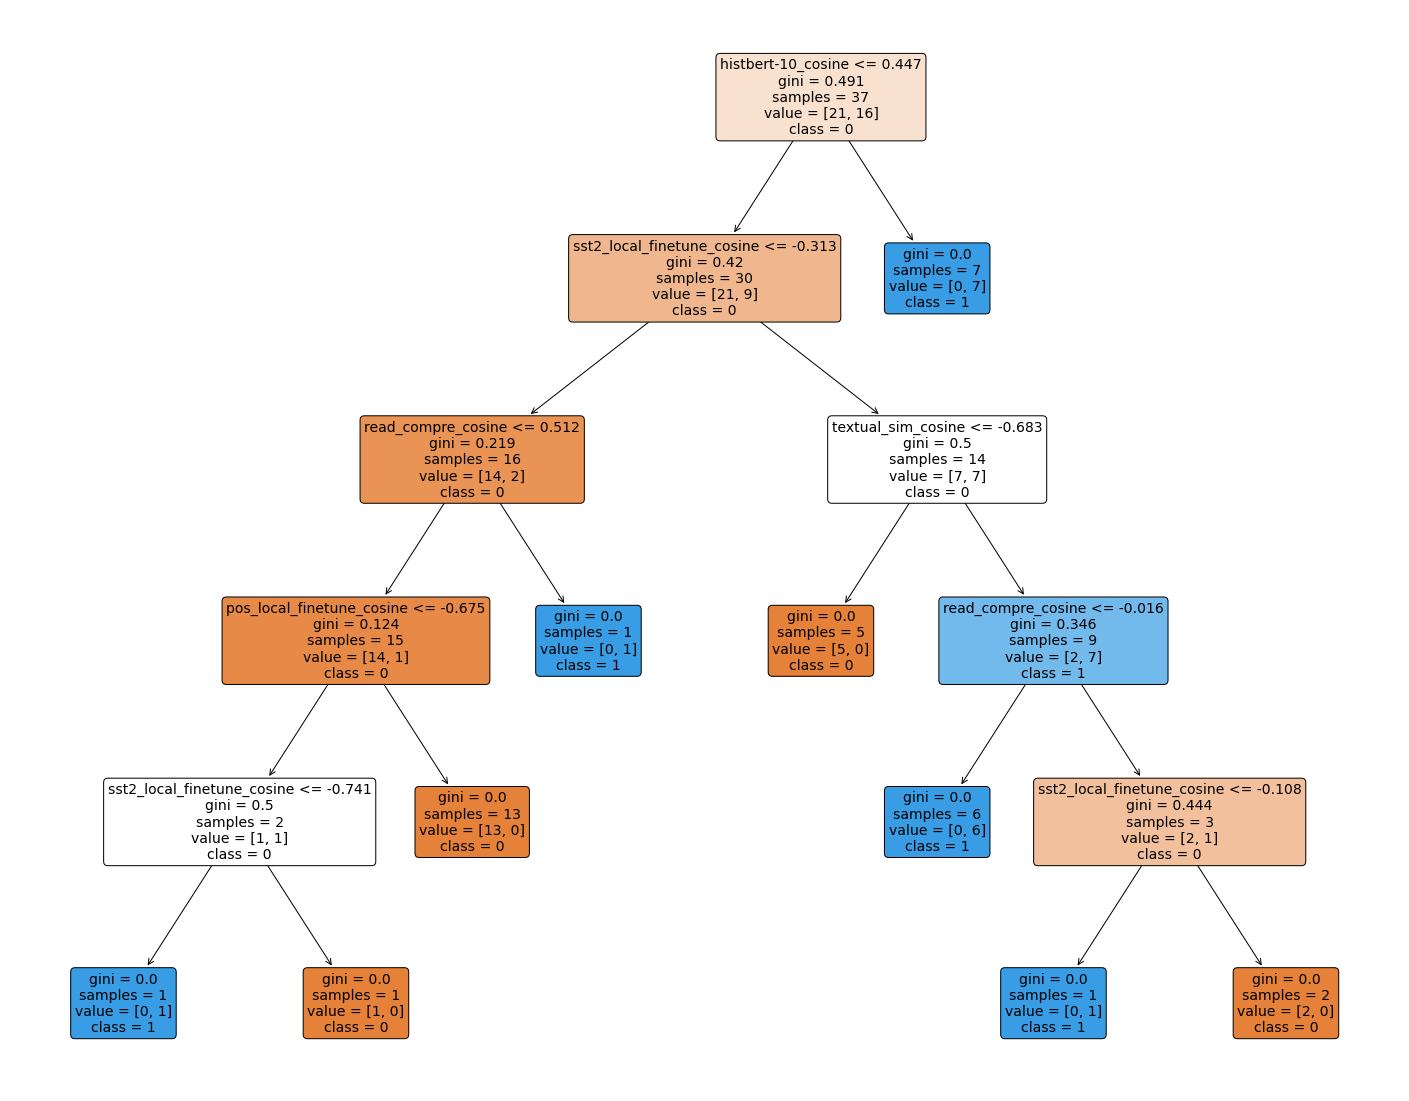

In [29]:
consider_features2=['pos_local_finetune_distance','textual_sim_distance','histbert-10_distance','ling_accept_distance','sst2_local_finetune_distance','read_compre_distance']
consider_features=['pos_local_finetune_cosine','textual_sim_cosine', 'histbert-10_cosine','ling_accept_cosine','sst2_local_finetune_cosine','read_compre_cosine']                    

new_dict = prepare_features('distance')
df2 = reformat_features(new_dict, gold_info_dis)
new_dict = prepare_features('cosine')
df1 = reformat_features(new_dict, gold_info_dis)
plot_tree_all_prune(df1,df2,consider_features, consider_features2)

## summary on dt results,

1. use train/test split on the three metrics and find PRT highest scores
2. if not normalize, results makes no sense
3. normalize with z scores, using prt results on apd fits better
4. prune seems not helpful

# analysis on combinations

APD: best 10

('bert_base', 'snli', 'textual_sim', 'error_detect', 'pos_local_finetune') 0.7234572406776069

('bert_base', 'sst2', 'error_detect', 'pos_local_finetune') 0.7223901945999114

('sst2', 'textual_sim', 'error_detect') 0.7216788305481142

('bert_base', 'sst2', 'textual_sim', 'error_detect') 0.7215602698728146

('bert_base', 'textual_sim', 'error_detect') 0.7213231485222157

('bert_base', 'sst2', 'textual_sim', 'error_detect', 'pos_local_finetune') 0.7213231485222157

('bert_base', 'snli', 'error_detect') 0.7212045878469161

('bert_base', 'textual_sim', 'pos_local_finetune') 0.7212045878469161

('bert_base', 'snli', 'error_detect', 'pos_local_finetune') 0.7206117844704186

('bert_base', 'snli', 'textual_sim', 'error_detect') 0.7203746631198197

APD: worst 10

('pos_local_finetune', 'sst2_local_finetune') -0.2140020189156146

('sst2_local_finetune',) -0.2104451986566293

('pos_local_finetune',) 0.08737921769573849

('pos_local_finetune', 'pos', 'sst2_local_finetune') 0.09271444808421642

('pos', 'sst2_local_finetune') 0.12188037420789576

('sst2_local_finetune', 'histbert-full') 0.13041674282946045

('pos_local_finetune', 'pos', 'sst2_local_finetune', 'phrase_chunk') 0.13148378890715604

('sst2_local_finetune', 'phrase_chunk') 0.1359890945685374

('pos_local_finetune', 'sst2_local_finetune', 'phrase_chunk') 0.13670045862033445

('pos', 'sst2_local_finetune', 'phrase_chunk') 0.14345841711240645


=======================================================================

PRT best 10

('snli', 'pos_local_finetune', 'sst2_local_finetune') 0.5311518253418026

('snli', 'sst2_pfeiffer', 'pos_local_finetune', 'ner', 'sst2_local_finetune') 0.5149090128257697

('bert_base', 'snli', 'sst2_pfeiffer', 'ner', 'sst2_local_finetune') 0.5031715059711183

('snli', 'sst2_pfeiffer', 'pos_local_finetune', 'sst2_local_finetune') 0.5025787025946208

('snli', 'read_compre', 'sst2_pfeiffer', 'histbert-10', 'pos_local_finetune', 'sst2_local_finetune') 0.5022230205687221

('snli', 'sst2_pfeiffer', 'pos_local_finetune', 'ner') 0.5019858992181231

('bert_base', 'sst2_hously', 'snli', 'read_compre', 'sst2_pfeiffer', 'histbert-10', 'histbert', 'pos_local_finetune', 'sem_tag', 'ner') 0.5009188531404276

('snli', 'read_compre', 'sst2_pfeiffer', 'pos_local_finetune', 'sst2_local_finetune') 0.5002074890886306

('snli', 'read_compre', 'pos_local_finetune', 'sem_tag', 'ner') 0.49937756436153397

('snli', 'read_compre', 'sst2_pfeiffer', 'pos_local_finetune', 'ner', 'sst2_local_finetune') 0.4989033216603359

PRT worst 10

('sst2_local_finetune', 'histbert-full') 0.011737506854651438

('pos_local_finetune', 'sst2_local_finetune', 'histbert-full') 0.01387159901004261

('pos_local_finetune', 'histbert-full') 0.037939416095843045

('histbert-full',) 0.044104571211417525

('ner', 'sst2_local_finetune', 'histbert-full') 0.07421898273749294

('phrase_chunk',) 0.07611595354228509

('pos_local_finetune', 'ner', 'sst2_local_finetune', 'histbert-full') 0.08180686595666155

('sst2_local_finetune', 'phrase_chunk') 0.08773489972163702

('pos_local_finetune', 'ner', 'histbert-full') 0.10160649873167962

('ner', 'histbert-full') 0.10623036506836049



=====================================================

JSD bset 10



JSD worst 10

('pos_local_finetune',) -0.057501927520262106

('phrase_chunk',) -0.04386744986081851

('pos_local_finetune', 'sst2_local_finetune') -0.020155314800916615

('pos_local_finetune', 'phrase_chunk') 0.018732586697322497

('sem_tag', 'phrase_chunk') 0.020155314800916615

('sst2_local_finetune', 'phrase_chunk') 0.02335645303400337

('pos_local_finetune', 'sem_tag', 'sst2_local_finetune', 'phrase_chunk') 0.031537139629669524

('pos_local_finetune', 'sst2_local_finetune', 'phrase_chunk') 0.03402691381095922

('sem_tag', 'sst2_local_finetune', 'phrase_chunk') 0.054063667936576326

('pos_local_finetune', 'sem_tag') 0.056553442117866025


# task 1

In [26]:
# use ave to determine the threshold
import math
import os
def threshold(path,k):
    scores = []
    with open(path,'r') as f:
        for line in f:
            token, score = line.split('\t')
            scores.append(float(score[:-1]))
    sorted_scores = sorted(scores,reverse = True)
    n = math.floor(len(sorted_scores)*k/100)
    return sorted_scores[n-1]



def assign_score(path,t,metric,filename, k):
    result=[]
    with open(path,'r') as f:
        for line in f:
            token, score = line.split('\t')
            if float(score[:-1])>=t:
                score=1
            else:
                score=0
            result.append((token,score))
   
    with open(os.path.join(f"results/task1_{metric}/{k}", filename),'w') as f:
        for item in result:
            f.write(item[0]+'\t'+str(item[1])+'\n')
        print(f'finishing {filename}')
                     
        
    return result

def read_in(metric,k):
    t = threshold(f'results/{metric}_ave',k)
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            assign_score(path,t,metric,filename, k)


In [33]:
for item in ['cosine','distance','jsd']:
    for i in [10,20,30,40,50,60]:
        read_in(item,i)

bert_base
finishing bert_base
error_detect
finishing error_detect
histbert
finishing histbert
histbert-10
finishing histbert-10
histbert-5
finishing histbert-5
histbert-full
finishing histbert-full
ling_accept
finishing ling_accept
ner
finishing ner
phrase_chunk
finishing phrase_chunk
pos
finishing pos
pos_local_finetune
finishing pos_local_finetune
read_compre
finishing read_compre
sem_tag
finishing sem_tag
snli
finishing snli
sst2
finishing sst2
sst2_hously
finishing sst2_hously
sst2_local_finetune
finishing sst2_local_finetune
sst2_pfeiffer
finishing sst2_pfeiffer
textual_sim
finishing textual_sim
bert_base
finishing bert_base
error_detect
finishing error_detect
histbert
finishing histbert
histbert-10
finishing histbert-10
histbert-5
finishing histbert-5
histbert-full
finishing histbert-full
ling_accept
finishing ling_accept
ner
finishing ner
phrase_chunk
finishing phrase_chunk
pos
finishing pos
pos_local_finetune
finishing pos_local_finetune
read_compre
finishing read_compre
sem_ta

In [35]:
# evaluate on the gold file first
gold_path = '../test_data_truth/task1/english.txt'
scores = {}
with open(gold_path,'r') as f:
    for line in f:
        token, score = line.split('\t')
        scores[token]=float(score[:-1])
print(scores)

{'attack': 1.0, 'bag': 0.0, 'ball': 0.0, 'bit': 1.0, 'chairman': 0.0, 'circle': 1.0, 'contemplation': 0.0, 'donkey': 0.0, 'edge': 1.0, 'face': 0.0, 'fiction': 0.0, 'gas': 0.0, 'graft': 1.0, 'head': 1.0, 'land': 1.0, 'lane': 0.0, 'lass': 1.0, 'multitude': 0.0, 'ounce': 0.0, 'part': 0.0, 'pin': 0.0, 'plane': 1.0, 'player': 1.0, 'prop': 1.0, 'quilt': 0.0, 'rag': 1.0, 'record': 1.0, 'relationship': 0.0, 'risk': 0.0, 'savage': 0.0, 'stab': 1.0, 'stroke': 0.0, 'thump': 1.0, 'tip': 1.0, 'tree': 0.0, 'twist': 0.0, 'word': 0.0}


In [49]:
from sklearn.metrics import accuracy_score
token_list=list(scores.keys())
def evaluate(metric,scores):
    all_results={}
    for k in [10,20,30,40,50,60]:
        for filename in os.listdir(f"results/task1_{metric}/{k}"):
            if filename!='discovery_noun' and filename!='discovery_verb': 
                scores_eval = {}
                with open(os.path.join(f"results/task1_{metric}/{k}", filename),'r') as f:
                    for line in f:
                        token, score = line.split('\t')
                        scores_eval[token]=float(score[:-1])
                y_pred = [scores_eval[token] for token in token_list]
                field=metric+'|'+filename+'|'+str(k)
                all_results[field]=accuracy_score(list(scores.values()), y_pred)
    dict_ = {k: v for k, v in sorted(all_results.items(), key=lambda item: item[1], reverse=True)}             
    return dict_
cosine_results = evaluate('cosine',scores)
distance_results = evaluate('distance',scores)
jsd_results = evaluate('jsd',scores)
                
                
                
                
        

In [53]:
# store results into a file
import pandas as pd
import csv
agg=[]
for k,v in cosine_results.items():
    metric, filename, threshold = k.split('|')
    agg.append({'metric':metric,'filename':filename,'threshold':threshold,'accuracy':float(v)})
    
for k,v in distance_results.items():
    metric, filename, threshold = k.split('|')
    agg.append({'metric':metric,'filename':filename,'threshold':threshold,'accuracy':float(v)})
    
for k,v in jsd_results.items():
    metric, filename, threshold = k.split('|')
    agg.append({'metric':metric,'filename':filename,'threshold':threshold,'accuracy':float(v)})
    
keys = agg[0].keys()
with open('acc.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(agg)
    
pd.read_csv('acc.csv')

    

,metric,filename,threshold,accuracy
0,cosine,histbert-10,10,0.729730
1,cosine,error_detect,10,0.702703
2,cosine,error_detect,20,0.702703
3,cosine,nli,60,0.702703
4,cosine,histbert-5,10,0.675676
...,...,...,...,...
337,jsd,ner,50,0.486486
338,jsd,ner,60,0.486486
339,jsd,textual_sim,60,0.486486
340,jsd,ner,40,0.459459


In [72]:
#majority vote 
from collections import defaultdict

def majority_vote_task1(metric,k):
    scores_new=[]
    tmp = defaultdict(list)
    for filename in os.listdir(f"results/task1_{metric}/{k}"):
        if filename!='discovery_noun' and filename!='discovery_verb': 
            scores_eval = {}
            with open(os.path.join(f"results/task1_{metric}/{k}", filename),'r') as f:
                for line in f:
                    token, score = line.split('\t')
                    tmp[token].append(float(score[:-1]))
                                      
                                      
    for token, v_list in tmp.items():
        if sum(list(v_list))>len(os.listdir(f"results/task1_{metric}/{k}"))/2:
            scores_new.append((token,1))
        else:
            scores_new.append((token,0))
                                      
    with open(os.path.join(f"results/task1_{metric}/majority_vote_{k}"),'w') as f:
        for item in scores_new:
            f.write(item[0]+'\t'+str(item[1])+'\n')


In [73]:
for item in ['cosine','distance','jsd']:
    for i in [10,20,30,40,50,60]:
        majority_vote_task1(item,i)

In [76]:
# does majority vote improve general results?
# evaluate on the gold file first
gold_path = '../test_data_truth/task1/english.txt'
scores = {}
with open(gold_path,'r') as f:
    for line in f:
        token, score = line.split('\t')
        scores[token]=float(score[:-1])
token_list=list(scores.keys())

def evaluate_ma(metric,scores,k):
    scores_eval={}
    with open(f'results/task1_{metric}/majority_vote_{k}','r') as f:
        for line in f:
            token, score = line.split('\t')
            scores_eval[token]=float(score[:-1])
    y_pred = [scores_eval[token] for token in token_list]
    print(metric,k,accuracy_score(list(scores.values()), y_pred))
    return

for item in ['cosine','distance','jsd']:
    for i in [10,20,30,40,50,60]:
        evaluate_ma(item,scores,i)

                

cosine 10 0.5945945945945946
cosine 20 0.6216216216216216
cosine 30 0.6486486486486487
cosine 40 0.6486486486486487
cosine 50 0.5945945945945946
cosine 60 0.4864864864864865
distance 10 0.5675675675675675
distance 20 0.6756756756756757
distance 30 0.6756756756756757
distance 40 0.6756756756756757
distance 50 0.6756756756756757
distance 60 0.6486486486486487
jsd 10 0.6216216216216216
jsd 20 0.6216216216216216
jsd 30 0.5945945945945946
jsd 40 0.5675675675675675
jsd 50 0.5405405405405406
jsd 60 0.5135135135135135


In [78]:
df = pd.read_csv("acc.csv")
for item in ['cosine','distance','jsd']:
    for i in [10,20,30,40,50,60]:
        scores = df[(df['metric']==item)&(df['threshold']==i)]['accuracy']
        print(item, i, max(scores),sum(scores)/len(scores),min(scores))

cosine 10 0.7297297297297297 0.6230440967283075 0.5675675675675675
cosine 20 0.7027027027027027 0.588904694167852 0.4864864864864865
cosine 30 0.6756756756756757 0.5874822190611666 0.4594594594594595
cosine 40 0.6486486486486487 0.5903271692745379 0.5135135135135135
cosine 50 0.6486486486486487 0.5704125177809388 0.4594594594594595
cosine 60 0.7027027027027027 0.5533428165007112 0.4324324324324325
distance 10 0.6486486486486487 0.5803698435277382 0.5135135135135135
distance 20 0.7297297297297297 0.5903271692745377 0.4594594594594595
distance 30 0.7027027027027027 0.5803698435277382 0.4594594594594595
distance 40 0.7027027027027027 0.5775248933143672 0.4594594594594595
distance 50 0.7297297297297297 0.5647226173541963 0.4324324324324325
distance 60 0.7297297297297297 0.5576102418207681 0.4324324324324325
jsd 10 0.6756756756756757 0.6073968705547654 0.5675675675675675
jsd 20 0.7027027027027027 0.5832147937411095 0.4864864864864865
jsd 30 0.7297297297297297 0.5732574679943101 0.4864864864

# MISC

In [64]:
single_case = df_cosine[(df_cosine['task']=='gold.txt')|(df_cosine['task']=='pos')]

In [62]:
single_case

,task,metric,token,score
2410,gold.txt,distance,attack,0.143970
2411,gold.txt,distance,bag,0.100364
2412,gold.txt,distance,ball,0.409367
2413,gold.txt,distance,bit,0.306577
2414,gold.txt,distance,chairman,0.000000
...,...,...,...,...
2664,ner,distance,stab,1.003967
2665,ner,distance,twist,1.003516
2666,ner,distance,attack,1.003439
2667,ner,distance,gas,1.010593


In [48]:
decrease={}
with open('results/cosine/gold.txt','r') as f:
    for line in f:
        token, score = line.split('\t')
        decrease[token]=float(score[:-1])
increase = {k: v for k, v in sorted(decrease.items(), key=lambda item: item[1])}        
print(increase)
increase_list = list(increase.keys())
print(increase_list)

{'chairman': 0.0, 'risk': 0.0, 'fiction': 0.0207232682, 'relationship': 0.0562177896, 'contemplation': 0.070838721, 'tree': 0.070838721, 'savage': 0.0968689424, 'bag': 0.1003636619, 'multitude': 0.1003636619, 'lane': 0.1037200629, 'quilt': 0.1231453661, 'face': 0.137791275, 'thump': 0.1429915711, 'attack': 0.1439699927, 'gas': 0.1595695865, 'donkey': 0.1601038896, 'part': 0.161270809, 'circle': 0.1710871199, 'stroke': 0.1762311532, 'word': 0.1793071623, 'pin': 0.2072118595, 'lass': 0.2125896937, 'land': 0.2234476353, 'edge': 0.2609655868, 'player': 0.2736674651, 'rag': 0.2765152931, 'ounce': 0.2848990681, 'head': 0.2952561247, 'bit': 0.3065766263, 'twist': 0.3984926634, 'stab': 0.4005896829, 'ball': 0.4093665525, 'record': 0.4273504707, 'graft': 0.5539755971, 'prop': 0.624759971, 'tip': 0.6788987615, 'plane': 0.8823475834}
['chairman', 'risk', 'fiction', 'relationship', 'contemplation', 'tree', 'savage', 'bag', 'multitude', 'lane', 'quilt', 'face', 'thump', 'attack', 'gas', 'donkey', '

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

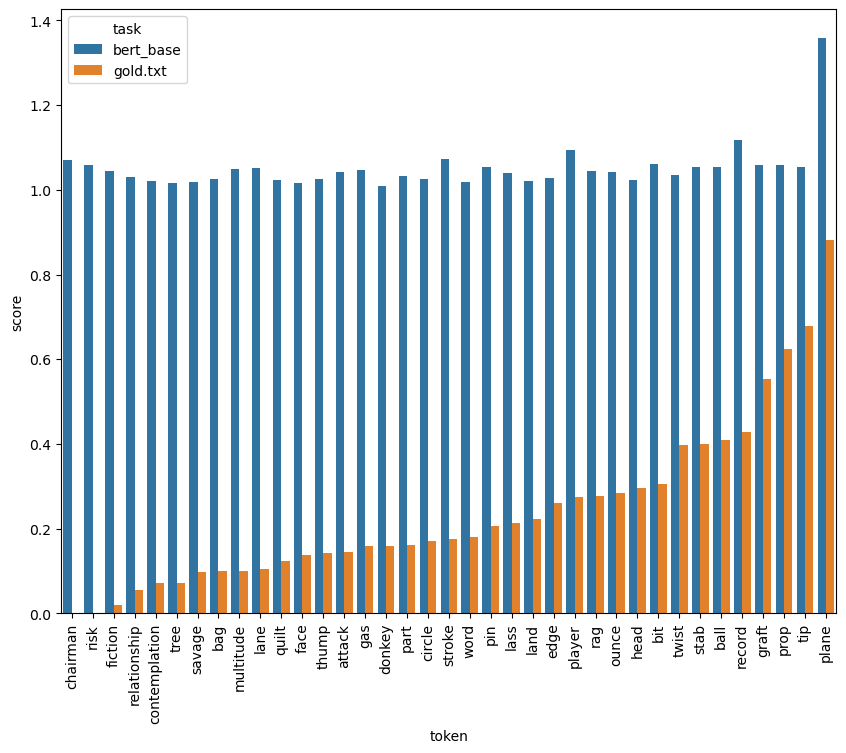

In [49]:
import seaborn as sns
from matplotlib.pyplot import figure
order_list = ['first', 'second', 'third']
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)